In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.4 MB/s eta 0:00:00


In [2]:
!unzip '/content/drive/MyDrive/DL-Project/Text-To-Image/flicker-text-to-image.zip'

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v4idhuyy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v4idhuyy
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=e053040402b910268ab196311ffba9491af663765726a2a2d4911b37fa949db8
  Stored in directory: /tmp/pip-ephem-wheel-cache-arl78c69/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [1]:
import torch
import torchvision
from torchvision import transforms
from transformers import AutoTokenizer,AutoModel
from torchsummary import summary
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import clip
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# Create New Version of ResNet-Block
class ResNetBlock(nn.Module):
    def __init__(self,channels):
        super(ResNetBlock,self).__init__()
        self.gn = nn.GroupNorm(1,channels)
        self.sact = nn.SiLU(inplace=True)
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(channels,channels,kernel_size=(1,1),stride=1)

    def forward(self,x):
        temp = self.conv2(x)
        x = self.sact(self.gn(x))
        x = self.conv1(x)
        x = self.sact(self.gn(x))
        output = x + temp
        return output


class SelfAttention(nn.Module):
    def __init__(self, in_channel):
        super(SelfAttention, self).__init__()

        #conv f
        self.conv_f = nn.utils.spectral_norm(nn.Conv2d(in_channel, in_channel//8, 1))
        #conv_g
        self.conv_g = nn.utils.spectral_norm(nn.Conv2d(in_channel, in_channel//8, 1))
        #conv_h
        self.conv_h = nn.utils.spectral_norm(nn.Conv2d(in_channel, in_channel, 1))

        self.softmax = nn.Softmax(-2) #sum in column j = 1
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        f_projection = self.conv_f(x) #BxC'xHxW, C'=C//8
        g_projection = self.conv_g(x) #BxC'xHxW
        h_projection = self.conv_h(x) #BxCxHxW

        f_projection = torch.transpose(f_projection.view(B,-1,H*W), 1, 2) #BxNxC', N=H*W
        g_projection = g_projection.view(B,-1,H*W) #BxC'xN
        h_projection = h_projection.view(B,-1,H*W) #BxCxN

        attention_map = torch.bmm(f_projection, g_projection) #BxNxN
        attention_map = self.softmax(attention_map) #sum_i_N (A i,j) = 1

        #sum_i_N (A i,j) = 1 hence oj = (HxAj) is a weighted sum of input columns
        out = torch.bmm(h_projection, attention_map) #BxCxN
        out = out.view(B,C,H,W)

        out = self.gamma*out + x
        return out

class DBBlock(nn.Module):
    def __init__(self,channels,out_channels,stride,num_resblock,attention=False):
        super(DBBlock,self).__init__()
        self.is_atten = attention
        self.conv1 = nn.Conv2d(channels,out_channels,kernel_size=(3,3),stride=stride)
        self.res = ResNetBlock(out_channels+1)
        self.attention = SelfAttention(out_channels+1)#,output_size=43*2)
        self.num_resblock = num_resblock

    def forward(self,x,emb_value):
        x = self.conv1(x)
        x = torch.cat([x,emb_value],axis=1)
        for i in range(self.num_resblock):
            x = self.res(x)
        if self.is_atten:
            x = self.attention(x)
        return x

class UBBlock(nn.Module):
    def __init__(self,channels,out_channel,stride=2,num_resblock=1,is_atten=False,is_dropout=False):
        super(UBBlock,self).__init__()
        self.is_atten = is_atten
        self.tconv = nn.ConvTranspose2d(channels+1,out_channel,kernel_size=(3,3),stride=stride)
        self.res = ResNetBlock(channels+1)
        self.attention = SelfAttention(channels+1)
        self.num_resblock = num_resblock
        self.droplayer = nn.Dropout(0.4)
        self.is_dropout = is_dropout
    def forward(self,x,emb_value):
        x = torch.cat([x,emb_value],axis=1)
        for i in range(self.num_resblock):
            x = self.res(x)
        if self.is_atten:
            x = self.attention(x)
        if self.is_dropout:
            x = self.droplayer(x)
        x = self.tconv(x)
        return x


In [3]:
import math
def cosine_noise_schedule(t):
    """
    Create a cosine noise schedule.

    Args:
        t (float): The current time step.

    Returns:
        Tensor: A tensor of shape (1,) that represents the noise level.
    """
    return 0.5 * (1 + torch.cos(math.pi * t))


In [5]:
class Generator(nn.Module):
    def __init__(self,input_channel,output_channel,emb_size,img_size):
        super(Generator,self).__init__()
        self.linear = nn.Linear(emb_size,img_size*img_size)
        self.act = nn.ReLU(inplace=True)
        # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.dblock1 = DBBlock(input_channel,256,stride=2,num_resblock=4)
        self.dblock2 = DBBlock(257,128,stride=2,num_resblock=4)
        self.dblock3 = DBBlock(129,64,stride=2,num_resblock=4)
        self.dblock4 = DBBlock(65,32,stride=2,num_resblock=4)
        self.dblock5 = DBBlock(33,16,stride=2,num_resblock=4,attention=True)

        self.ublock1 = UBBlock(17,17,stride=2,num_resblock=4)
        self.ublock2 = UBBlock(50,32,stride=2,num_resblock=4,is_dropout=True)
        self.ublock3 = UBBlock(97,64,stride=2,num_resblock=4)
        self.ublock4 = UBBlock(193,128,stride=2,num_resblock=4)
        self.ublock5 = UBBlock(385,256,stride=2,num_resblock=4,is_atten=True,is_dropout=True)
        self.conv1 = nn.Conv2d(3,3,kernel_size=3,stride=1)
        self.conv2 = nn.ConvTranspose2d(256,output_channel,kernel_size=2,stride=1) # Las output return
        self.conv3 = nn.Conv2d(1,1,kernel_size=3,stride=2)
        self.conv4 = nn.ConvTranspose2d(1,1,kernel_size=3,stride=2)
        # self.decoder = Decoder()
    def forward(self,x,emb_value):
        embedding  = self.linear(emb_value).view(1,1,256,256)
        embedding = self.act(self.conv3(embedding))
        # embedding = self.act(self.conv3(embedding))
        db1 = self.act(self.dblock1(x,embedding))
        embedding = self.conv3(embedding)
        db2 = self.act(self.dblock2(db1,embedding))
        embedding = self.conv3(embedding)
        db3 = self.act(self.dblock3(db2,embedding))
        embedding = self.conv3(embedding)
        db4 = self.act(self.dblock4(db3,embedding))
        embedding = self.conv3(embedding)
        db5 = self.act(self.dblock5(db4,embedding))
        ub1 = self.act(self.ublock1(db5,embedding))
        embedding = self.conv4(embedding)

        ub2 = self.act(self.ublock2(torch.cat([ub1,db4],dim=1),embedding))
        embedding = self.conv4(embedding)
        ub3 = self.act(self.ublock3(torch.cat([ub2,db3],dim=1),embedding))
        embedding = self.conv4(embedding)
        ub4 = self.act(self.ublock4(torch.cat([ub3,db2],dim=1),embedding))
        embedding = self.conv4(embedding)
        ub5 = self.act(self.ublock5(torch.cat([ub4,db1],dim=1),embedding))
        output = self.conv2(ub5)

        return output


embedding_dim = 512
image_channels = 3
image_size = 256  # Reduced image size for this example
output_channel = 3
# Create an instance of the generator
generator = nn.DataParallel(Generator(image_channels,output_channel,embedding_dim, image_size).to(device))
generator

DataParallel(
  (module): Generator(
    (linear): Linear(in_features=512, out_features=65536, bias=True)
    (act): ReLU(inplace=True)
    (dblock1): DBBlock(
      (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2))
      (res): ResNetBlock(
        (gn): GroupNorm(1, 257, eps=1e-05, affine=True)
        (sact): SiLU(inplace=True)
        (conv1): Conv2d(257, 257, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(257, 257, kernel_size=(1, 1), stride=(1, 1))
      )
      (attention): SelfAttention(
        (conv_f): Conv2d(257, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv_g): Conv2d(257, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv_h): Conv2d(257, 257, kernel_size=(1, 1), stride=(1, 1))
        (softmax): Softmax(dim=-2)
      )
    )
    (dblock2): DBBlock(
      (conv1): Conv2d(257, 128, kernel_size=(3, 3), stride=(2, 2))
      (res): ResNetBlock(
        (gn): GroupNorm(1, 129, eps=1e-05, affine=True)
        (sact): SiLU(inplace=Tru

In [6]:
def create_t_parameter(batch_size):
    """
    Create a tensor that represents the current time step.

    Args:
        batch_size (int): The batch size.

    Returns:
        Tensor: A tensor of shape (batch_size,) that represents the current time step.
    """
    t = torch.rand(batch_size)
    t = t.clamp(0, 1)

    return t

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(64),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(128),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(256),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(512),
            nn.Conv2d(512, 1, 4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x.view(-1)

disc = nn.DataParallel(Discriminator().to(device))
disc

DataParallel(
  (module): Discriminator(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (12): Con

In [8]:
import pandas as pd
pd_df = pd.read_excel("/content/drive/MyDrive/DL-Project/Text-To-Image/results.xlsx")
pd_df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [9]:
pd_df.drop("comment_number",axis=1,inplace=True)
pd_df.to_numpy()

array([['1000092795.jpg',
        'Two young guys with shaggy hair look at their hands while hanging out in the yard .'],
       ['1000092795.jpg',
        'Two young , White males are outside near many bushes .'],
       ['1000092795.jpg',
        'Two men in green shirts are standing in a yard .'],
       ...,
       ['998845445.jpg',
        'A man is leaning off of the side of a blue and white boat as it sits in a body of water .'],
       ['998845445.jpg',
        'A man riding a small boat in a harbor , with fog and mountains in the background .'],
       ['998845445.jpg',
        'A man on a moored blue and white boat with hills and mist in the background .']],
      dtype=object)

In [10]:
image_with_text = pd_df.to_numpy().squeeze()

Length of the Dataset:158915


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([1, 512])


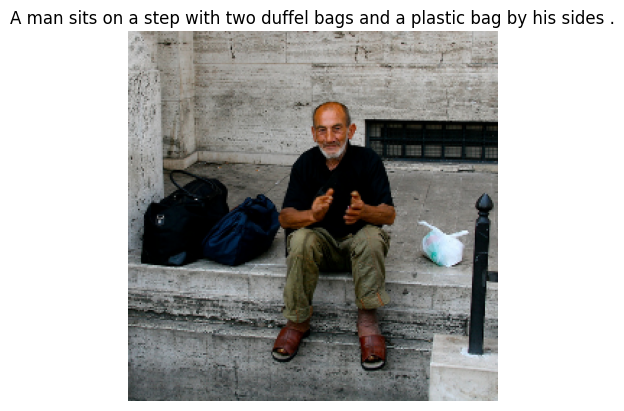

In [11]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
class CustomDataset(Dataset):
    def __init__(self,image_with_text,emb_size=40,target_imgsize=(256,256)):
        self.model, self.preprocess = clip.load("ViT-B/32",device='cpu')
        self.image_with_text = image_with_text
        self.target_imgsize = target_imgsize
        self.transform = transforms.Compose([
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Resize(target_imgsize),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
        ])
    def __len__(self):
        return len(self.image_with_text)
    def __getitem__(self,idx):
        base_dir = "/content/flickr30k_images/flickr30k_images/"
        image_path = base_dir + self.image_with_text[idx][0]
        src_text = self.image_with_text[idx][1]
        with torch.no_grad():
            text = clip.tokenize([src_text])
            emb_value = self.model.encode_text(text)
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        return image,emb_value.squeeze(0),src_text

dataset = CustomDataset(image_with_text)
dataloader = DataLoader(dataset,batch_size=1,shuffle=True,num_workers=4)
print(f"Length of the Dataset:{len(dataloader)}")

reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
item = next(iter(dataloader))
print(item[1].shape)
plt.imshow(reverse_transforms(item[0].squeeze()))
plt.title(item[2][0])
plt.axis('off')
plt.show()

In [12]:
import math
import torch
import torch.optim as optim

beta_value = (0.5,0.999) # It's control how much the optimizer rememeber previous gradient.

# Create the optimizer with Adam (or any other optimizer you prefer)
g_optim = optim.Adam(generator.parameters(), lr=0.0002,betas=beta_value)

d_optim = optim.Adam(disc.parameters(),lr=0.0002,betas=beta_value)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

if_pretrain = True
if if_pretrain:
    print("Using pretrained model")
    gan_statedict = torch.load("/content/drive/MyDrive/DL-Project/Text-To-Image/DGenerator.pth")
    generator.load_state_dict(gan_statedict)
    disc_statedict = torch.load("/content/drive/MyDrive/DL-Project/Text-To-Image/DClassifier.pth")
    disc.load_state_dict(disc_statedict)
else:
    generator = generator.apply(weights_init)
    disc = disc.apply(weights_init)


Using pretrained model


## Feature Matching Loss Function

In [13]:
import torch
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms

# Load a pretrained AlexNet model
alexnet = models.alexnet(pretrained=True).to(device)
alexnet_features = alexnet.features

# Define a transform to preprocess images for the AlexNet model
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to AlexNet input size
])

def feature_matching_loss(generate, target):
    # Preprocess input and target images
    generate = preprocess(generate)
    target = preprocess(target)

    # Calculate AlexNet feature maps
    generate_feature = alexnet_features(generate)
    target_features = alexnet_features(target)

    # Compute feature-wise L1 loss
    loss = 0.0
    for generate_feat, target_feat in zip(generate_feature, target_features):
        # Using as l1 loss for calculate feature difference between real and generated image.
        loss += torch.mean(torch.abs(generate_feat - target_feat))

    return loss

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Perceptual Loss Function

In [14]:
# Perceptual Loss using this project and see it's can help to GAN produce batter result.
import torch
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms

# Load a pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16_features = vgg16.features

# Define a transform to preprocess images for the VGG model
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to VGG input size
])

def perceptual_loss(input, target):
    # Preprocess input and target images
    input = preprocess(input)
    target = preprocess(target)

    # Calculate VGG feature maps
    input_features = vgg16_features(input)
    target_features = vgg16_features(target)

    # Compute feature-wise L1 loss
    loss = 0.0
    for input_feat, target_feat in zip(input_features, target_features):
        loss += F.l1_loss(input_feat, target_feat)

    return loss

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
from torchvision.utils import make_grid

def show_tensor_images(image_tensor,text, num_images=1, size=(3, 256, 256)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image_tensor.squeeze().detach().cpu()))
    plt.title(text)
    plt.axis('off')
    plt.show() # now time to showit


## Using as Diffusion teqnique

  0%|          | 0/158915 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in 

Epoch: 1/100, Batch: 1/158915, GAN Loss: 1.0636872053146362,Disc Loss: 1.4336693286895752


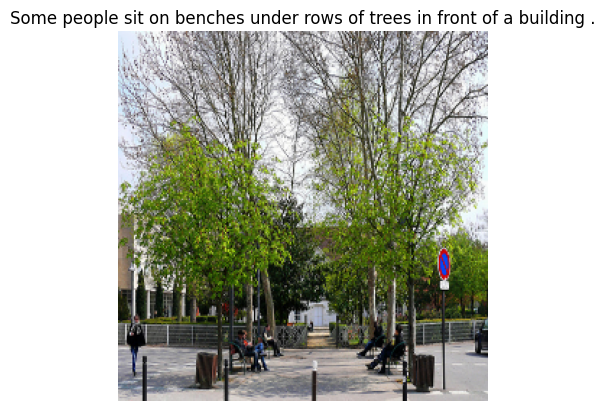

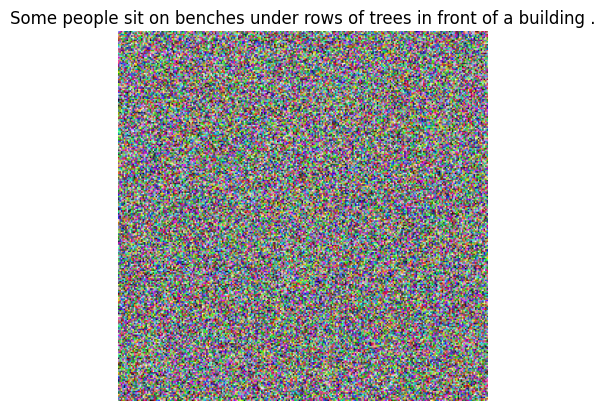

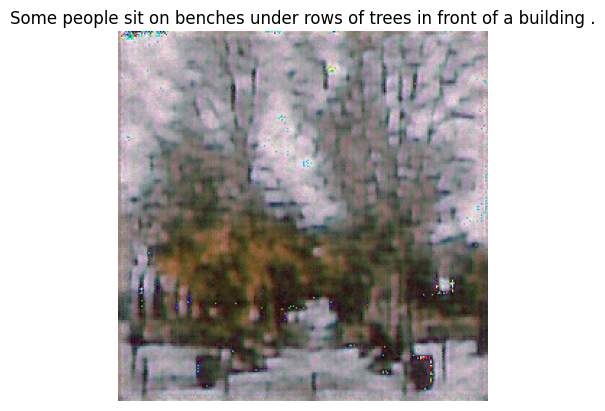

  0%|          | 59/158915 [01:05<46:56:20,  1.06s/it]

In [ ]:
epoch = 100
m_loss = nn.L1Loss()
ms_loss = nn.MSELoss()
bcloss = nn.BCELoss()
L1_lambda = 0.1
# Training loop
# noise_scheduale = [i/10 for i in range(1,10)]
for e in range(epoch):
    i = 0
    generator.train()
    disc.train()
    for (image, emb_value, token_ids) in tqdm(dataloader):
        image = image.to(device)
        emb_value = emb_value.to(device)
        initial_image = image.clone()
        for r in range(10):
            t = create_t_parameter(1).to(device)
            ct = cosine_noise_schedule(t).to(device)
            sample = torch.rand_like(image) + ct
            initial_image += sample
        with torch.no_grad():
            g_image = generator(initial_image,emb_value)
        d_optim.zero_grad()
        real_pred = disc(image)
        r_loss = bcloss(real_pred,torch.ones_like(real_pred))
        f_pred  = disc(g_image.detach())
        f_loss = bcloss(f_pred,torch.zeros_like(f_pred))
        d_loss = r_loss + f_loss
        d_loss.backward()
        d_optim.step()

        # Generator Train
        g_optim.zero_grad()
        g_image = generator(initial_image,emb_value)
        g_pred = disc(g_image)
        dg_loss = bcloss(g_pred,torch.ones_like(g_pred))
        lloss = m_loss(g_image,image)
        p_loss = perceptual_loss(g_image,image)
        fc_loss = feature_matching_loss(g_image,image)
        g_loss = dg_loss + lloss*L1_lambda + p_loss*lloss + lloss*fc_loss
        g_loss.backward()
        g_optim.step()

        if i%100 == 0:
            print(f"Epoch: {e+1}/{epoch}, Batch: {i+1}/{len(dataloader)}, GAN Loss: {g_loss.item()},Disc Loss: {d_loss.item()}")
            # Display images or other visualization as needed
            show_tensor_images(image, token_ids[0], num_images=1)
            show_tensor_images(initial_image,token_ids[0],num_images=1)
            show_tensor_images(g_image, token_ids[0], num_images=1)
            torch.save(generator.state_dict(),"/content/drive/MyDrive/DL-Project/Text-To-Image/DGenerator.pth")
            torch.save(disc.state_dict(),"/content/drive/MyDrive/DL-Project/Text-To-Image/DClassifier.pth")


        i+=1

        torch.cuda.empty_cache()



## Diffusion Model Test

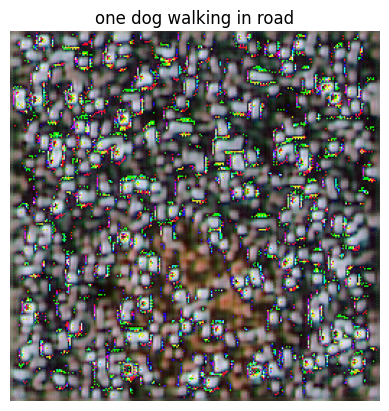

In [29]:
# Given text embedding and noise
# Prepare text embedding
model, preprocess = clip.load("ViT-B/32",device='cpu')

text = "one dog walking in road"
token_value  = clip.tokenize([text])
emb_value = model.encode_text(token_value)
emb_value = emb_value.to(device)

t = create_t_parameter(1).to(device)
ct = cosine_noise_schedule(t).to(device)
initial_noise = torch.randn((1, 3, 256, 256)).to(device)  # Initial noise for diffusion
initial_noise += ct

generator.eval()
fake_image = generator(initial_noise,emb_value)
show_tensor_images(fake_image,text,num_images=1)